In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import os
from nltk import wordpunct_tokenize
import re
import nn
import matplotlib.pyplot as plt

In [2]:
users = pd.read_csv('./dataset/users.dat', sep='::',
                        engine='python',
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pd.read_csv('./dataset/ratings.dat', engine='python',
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies_train = pd.read_csv('./dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')
movies_test = pd.read_csv('./dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False).set_index('movieid')                         
movies_train['genre'] = movies_train.genre.str.split('|')
movies_test['genre'] = movies_test.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [ ]:
import sys
import importlib
sys.path.insert(0, './params')
sys.path.insert(1, './metrics')
import param_rating
import map_at_k
importlib.reload(param_rating)
importlib.reload(map_at_k)
import pickle

import neural_metrics
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras import layers, models
import tensorflow as tf
from keras.models import load_model
from keras.saving import save_model


In [135]:
class ModelByTitle:
    def __init__(self,movie_train) :
        self.movie_train=movie_train.copy()
        self.movie_test=None
        self.submission_combined=None
        self.vectors_labels=None
    def tokenize(self,text):
        text = re.sub(r'[^\w\s]', '', text)
        text = text.lower()
        tokens = wordpunct_tokenize(text)
        tokens = tokens[:-1] # remove last token because it is the year which maybe is not useful
        return tokens

    def create_vocab(self):
        df = self.movie_train.copy()
        arr_title = df['title'].tolist()
        vocab = set()
        for title in arr_title:
            tokens = self.tokenize(title)
            vocab.update(tokens)
        vocab = list(vocab)
        pad_token = '<PAD>'
        unk_token = '<UNK>'
        vocab.append(pad_token)
        vocab.append(unk_token)
        return vocab

    def __preprocess_data_train(self):
        self.movie_train.reset_index(inplace=True)
        vocab=self.create_vocab()
        self.movie_train['title_tokens'] = [self.tokenize(x) for x in self.movie_train.title]
        # create vocab
        pad_token = '<PAD>'
        unk_token = '<UNK>'
        token2idx = {token: idx for idx, token in enumerate(vocab)}
        # Create a binary vector for each word in each sentence
        MAX_LENGTH = 7
        vectors = []
        for title_tokens in self.movie_train.title_tokens.tolist():
            if len(title_tokens) < MAX_LENGTH:
                num_pad = MAX_LENGTH - len(title_tokens)
                for _ in range(num_pad):
                    title_tokens.append(pad_token)
            else:
                title_tokens = title_tokens[:MAX_LENGTH]
            title_vectors = np.zeros(len(vocab))
            for word in title_tokens:
                if word in vocab:
                    title_vectors[token2idx[word]] = 1
                else:
                    title_vectors[token2idx[unk_token]] = 1

            vectors.append(np.array(title_vectors))
        self.movie_train['vectors'] = vectors 

        #preprocess label
        vectors_genre=[]
        for genre in self.movie_train.genre.tolist():
            genre_vector = np.zeros(len(param_rating.genre2idx))
            for g in genre:
                genre_vector[param_rating.genre2idx[g]] = 1
            vectors_genre.append(genre_vector)
        self.movie_train['genre_vectors']=vectors_genre

        genre_df = pd.DataFrame(self.movie_train['genre_vectors'].tolist(), columns=param_rating.genre2idx.keys())
        self.movie_train = pd.concat([self.movie_train, genre_df], axis=1)  

        self.x_train=np.expand_dims(self.movie_train['vectors'], 0)
        self.x_train=np.vstack(np.ravel(np.ravel(self.x_train))) 
        self.y_train=np.expand_dims(self.movie_train['genre_vectors'], 0)
        self.y_train=np.vstack(np.ravel(np.ravel(self.y_train))) 

        
    def __preprocess_data_test(self,movie_test):
        self.movie_test=movie_test.copy()
        self.movie_test.reset_index(inplace=True)
        self.movie_test['title_tokens'] = [self.tokenize(x) for x in self.movie_test.title]
        # create vocab
        vocab=self.create_vocab()

        pad_token = '<PAD>'
        unk_token = '<UNK>'
        token2idx = {token: idx for idx, token in enumerate(vocab)}
        # Create a binary vector for each word in each sentence
        MAX_LENGTH = 7
        vectors = []
        for title_tokens in self.movie_test.title_tokens.tolist():
            if len(title_tokens) < MAX_LENGTH:
                num_pad = MAX_LENGTH - len(title_tokens)
                for _ in range(num_pad):
                    title_tokens.append(pad_token)
            else:
                title_tokens = title_tokens[:MAX_LENGTH]
            title_vectors = np.zeros(len(vocab))
            for word in title_tokens:
                if word in vocab:
                    title_vectors[token2idx[word]] = 1
                else:
                    title_vectors[token2idx[unk_token]] = 1

            vectors.append(np.array(title_vectors))
        self.movie_test['vectors'] = vectors 

        #preprocess label
        vectors_genre=[]
        for genre in self.movie_test.genre.tolist():
            genre_vector = np.zeros(len(param_rating.genre2idx))
            for g in genre:
                genre_vector[param_rating.genre2idx[g]] = 1
            vectors_genre.append(genre_vector)
        self.movie_test['genre_vectors']=vectors_genre

        genre_test = pd.DataFrame(self.movie_test['genre_vectors'].tolist(), columns=param_rating.genre2idx.keys())
        self.movie_test = pd.concat([self.movie_test, genre_test], axis=1)

        self.x_test=np.expand_dims(self.movie_test['vectors'], 0)
        self.x_test=np.vstack(np.ravel(np.ravel(self.x_test))) 
        self.y_test=np.expand_dims(self.movie_test['genre_vectors'], 0)
        self.y_test=np.vstack(np.ravel(np.ravel(self.y_test))) 
    def preprocess_data(self):
        self.__preprocess_data_train()
    def train_model(self):
        #Logistic Regression with BorderlineSMOTE algorithm
        logreg_list=[]
        # for label in param_rating.genre2idx.keys():
        #     logreg = LogisticRegression(C=1.56)
        #     smote=BorderlineSMOTE(random_state=27,k_neighbors=5)
        #     smote_x_train,smote_y_train=smote.fit_resample(self.x_train,self.movie_train[label])
        #     print('... Processing {}'.format(label))

        #     logreg.fit(smote_x_train, smote_y_train)
        #     logreg_list.append(logreg)
        #     y_pred_X = logreg.predict(smote_x_train)
        #     print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))

        
        # with open('./trained_model_params/log_borderlineSMOTEmodelByTitle.pkl','wb') as file:
        #     pickle.dump(logreg_list,file)

        #Logistic Regression with SMOTEENN algorithm 
        # logreg_list.clear()
        # for label in param_rating.genre2idx.keys():
        #     logreg = LogisticRegression(C=1.44)
        #     smote=SMOTEENN(random_state=27)
        #     smote_x_train,smote_y_train=smote.fit_resample(self.x_train,self.movie_train[label])
        #     print('... Processing {}'.format(label))

        #     logreg.fit(smote_x_train, smote_y_train)
        #     logreg_list.append(logreg)
        #     y_pred_X = logreg.predict(smote_x_train)
        #     print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))
        # with open('./trained_model_params/log_borderlineSMOTEENNmodelByTitle.pkl','wb') as file:
        #     pickle.dump(logreg_list,file)
        
        #Gradient Boosting
        # logreg_list.clear()
        # for label in param_rating.genre2idx.keys():
        #     logreg = XGBClassifier(max_depth=6, learning_rate=1e-2) 
        #     smote=SMOTEENN(random_state=27)
        #     smote_x_train,smote_y_train=smote.fit_resample(self.x_train,self.movie_train[label])
        #     print('... Processing {}'.format(label))
        #     X_train, X_validation, Y_train, Y_validation = train_test_split(smote_x_train, 
        #                                                       smote_y_train, 
        #                                                       test_size=0.25)
        #     logreg.fit(X_train, Y_train, eval_metric="logloss", eval_set=[(X_validation, Y_validation)], early_stopping_rounds=10, verbose=True)
            
        #     logreg_list.append(logreg)
        #     y_pred_X = logreg.predict(smote_x_train)
        #     print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))
        # with open('./trained_model_params/gradientboostingbytitle.pkl','wb') as file:
        #     pickle.dump(logreg_list,file)

        #Neural network
        model = models.Sequential([
            layers.Dense(512, activation='relu', input_shape=(self.x_train.shape[1],)),
            layers.Dropout(0.8),
            layers.Dense(300, activation='relu'),
            layers.Dropout(0.8),
            layers.Dense(len(param_rating.genre2idx), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',neural_metrics.f1_m,neural_metrics.precision_m, neural_metrics.recall_m])
        model.fit(
            self.x_train, self.y_train,
            epochs=50,  
            batch_size=200
        )
        model.save('./trained_model_params/neuralbytitle.h5')
        # with open('./trained_model_params/neuralbytitle.pkl','wb') as file:
        #     pickle.dump(model,file)

        #SVM
            
        # svm_model=SVC(kernel='rbf', C=0.01, gamma=0.5385, probability=True)
        # multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)
        # multilabel_classifier = multilabel_classifier.fit(self.x_train, self.y_train)
        # with open('./trained_model_params/svm_modelByTitle.pkl', 'wb') as file:
        #     pickle.dump(multilabel_classifier, file)
        
        
        #Classifier Chains Technique for logistic regression
        # logreg_list.clear()
        # data_classifier=self.movie_train.copy()
        # x_train_classfier=self.x_train.copy()
        # for label in param_rating.genre2idx.keys():
        #     logreg_classifier = LogisticRegression(C=1.44)
        #     print('... Processing {}'.format(label))
        #     y = data_classifier[label]
        #     logreg_classifier.fit(x_train_classfier, y)
        #     logreg_list.append(logreg_classifier)
        #     y_pred_X = logreg_classifier.predict(x_train_classfier)
        #     print('Training accuracy is {}'.format(f1_score(y, y_pred_X)))
        #     x_train_classfier=self.__add_feature(x_train_classfier,y)
        # with open('./trained_model_params/log_chainsByTitle.pkl', 'wb') as file:
        #     pickle.dump(logreg_list, file)

    def __add_feature(self,X, feature_to_add):
            return hstack([X, csr_matrix(feature_to_add).T], 'csr')
    
    def predict(self,movie_test):
        self.__preprocess_data_test(movie_test)
        log_smote=pickle.load(open('./trained_model_params/log_borderlineSMOTEmodelByTitle.pkl', 'rb'))
        log_smoteenn=pickle.load(open('./trained_model_params/log_borderlineSMOTEENNmodelByTitle.pkl', 'rb'))
        boosting=pickle.load(open('./trained_model_params/gradientboostingbytitle.pkl', 'rb'))
        # neural=pickle.load(open('./trained_model_params/neuralbytitle.pkl', 'rb'))
        neural=load_model('./trained_model_params/neuralbytitle.h5', custom_objects={'f1_m': neural_metrics.f1_m, 
                                                               'precision_m': neural_metrics.precision_m, 
                                                               'recall_m': neural_metrics.recall_m})
        svm=pickle.load(open('./trained_model_params/svm_modelByTitle.pkl', 'rb'))
        log_chains=pickle.load(open('./trained_model_params/log_chainsByTitle.pkl', 'rb'))
        submission_binary = pd.DataFrame(columns=param_rating.genre2idx.keys())
        submission_binary_combined = pd.DataFrame(columns=param_rating.genre2idx.keys())
        submission_boost = pd.DataFrame(columns=param_rating.genre2idx.keys())
        submission_svm = pd.DataFrame(columns=param_rating.genre2idx.keys())
        submission_chains = pd.DataFrame(columns=param_rating.genre2idx.keys())
        #Logistic Regression with BorderlineSMOTE algorithm
        for label in param_rating.genre2idx.keys():
            test_y_prob = log_smoteenn[param_rating.genre2idx[label]].predict_proba(self.x_test)[:,1]
            submission_binary[label] = test_y_prob
        #Logistic Regression with SMOTEENN algorithm 
        for label in param_rating.genre2idx.keys():
            test_y_prob = log_smote[param_rating.genre2idx[label]].predict_proba(self.x_test)[:,1]
            submission_binary_combined[label] = test_y_prob
        #Gradient Boosting    
        for label in param_rating.genre2idx.keys():
            test_y_prob = boosting[param_rating.genre2idx[label]].predict_proba(self.x_test)[:,1]
            submission_boost[label] = test_y_prob
        #Neural network
        submission_neural = neural.predict(self.x_test)
        self.test_neural=submission_neural
        #SVM
        y_test_pred = svm.predict_proba(self.x_test)
        y_test_pred_svm=np.array(y_test_pred.copy())
        submission_svm = pd.DataFrame(columns=param_rating.genre2idx.keys())
        for label in param_rating.genre2idx.keys():
            submission_svm[label]=y_test_pred_svm[param_rating.genre2idx[label]][:,1]
        #Classifier Chains Technique for logistic regression
        x_test_classfier=self.x_test.copy()
        for label in param_rating.genre2idx.keys():
            test_y = log_chains[param_rating.genre2idx[label]].predict(x_test_classfier)
            test_y_prob = log_chains[param_rating.genre2idx[label]].predict_proba(x_test_classfier)[:,1]
            submission_chains[label] = test_y_prob
            x_test_classfier = self.__add_feature(x_test_classfier, test_y)
        self.submission_combined=(submission_binary_combined[param_rating.genre2idx.keys()]+submission_binary[param_rating.genre2idx.keys()]+submission_boost[param_rating.genre2idx.keys()]+submission_neural
                     +submission_chains[param_rating.genre2idx.keys()]+submission_svm[param_rating.genre2idx.keys()])/6
    def get_column_names(self,row):
        return list(self.vectors_labels.columns[row == 1])
    def evaluate_model(self):
        self.vectors_labels=pd.DataFrame(np.array(self.movie_test[param_rating.genre2idx.keys()]))
        sorted_prediction_ids = np.argsort(-self.submission_combined,axis=1)
        top_5_prediction_ids = sorted_prediction_ids[:,:5]
        vectors_labels_test_new=self.vectors_labels.apply(self.get_column_names,axis=1).tolist()
        print(map_at_k.mapk(vectors_labels_test_new,top_5_prediction_ids,k=5))       

In [136]:
model2=ModelByTitle(movies_train)
model2.preprocess_data()
model2.predict(movies_test)
model2.evaluate_model()

25/25 [==============================] - 0s 2ms/step
0.5557553982553982


# Add image path

## For movie-train

In [3]:
movies_train.reset_index(inplace=True)

## For movie test

In [4]:

movies_test.reset_index(inplace=True)

# Data Pre-Processing

In [5]:
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    tokens = wordpunct_tokenize(text)
    tokens = tokens[:-1] # remove last token because it is the year which maybe is not useful
    return tokens
def create_vocab():
    df = movies_train.copy()
    arr_title = df['title'].tolist()
    vocab = set()
    for title in arr_title:
        tokens = tokenize(title)
        vocab.update(tokens)
    vocab = list(vocab)
    pad_token = '<PAD>'
    unk_token = '<UNK>'
    vocab.append(pad_token)
    vocab.append(unk_token)
    return vocab

## Check whether some of examples are null

In [ ]:
movies_train.isnull().sum()

## Drop id column

In [ ]:
movies_train=movies_train.drop("id",axis=1)


In [7]:
movies_test=movies_test.drop("id",axis=1)

In [6]:
vocab = create_vocab()

In [26]:
movies_train

,movieid,title,genre
0,1650,Washington Square (1997),[Drama]
1,185,"Net, The (1995)","[Sci-Fi, Thriller]"
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3,3204,"Boys from Brazil, The (1978)",[Thriller]
4,1901,Dear Jesse (1997),[Documentary]
...,...,...,...
3101,2539,Analyze This (1999),[Comedy]
3102,3038,"Face in the Crowd, A (1957)",[Drama]
3103,1832,Heaven's Burning (1997),"[Action, Drama]"
3104,657,Yankee Zulu (1994),"[Comedy, Drama]"


## PreProcess Title

### Movie train

In [33]:
data =  movies_train.copy()
data['title_tokens'] = [tokenize(x) for x in data.title]
# create vocab
pad_token = '<PAD>'
unk_token = '<UNK>'
token2idx = {token: idx for idx, token in enumerate(vocab)}
# Create a binary vector for each word in each sentence
MAX_LENGTH = 7
vectors = []
for title_tokens in data.title_tokens.tolist():
    if len(title_tokens) < MAX_LENGTH:
        num_pad = MAX_LENGTH - len(title_tokens)
        for idx in range(num_pad):
            title_tokens.append(pad_token)
    else:
        title_tokens = title_tokens[:MAX_LENGTH]
    title_vectors = np.zeros(len(vocab))
    for word in title_tokens:
        if word in vocab:
            title_vectors[token2idx[word]] = 1
        else:
            title_vectors[token2idx[unk_token]] = 1

    vectors.append(np.array(title_vectors))
data['vectors'] = vectors 
# data['vectors'][0].shape #→7x3899

In [34]:
data[data['movieid']==3204]['vectors'].tolist()

[array([0., 0., 0., ..., 0., 1., 0.])]

### Movie test

In [44]:
data_test =  movies_test.copy()
data_test['title_tokens'] = [tokenize(x) for x in data_test.title]
# create vocab
pad_token = '<PAD>'
unk_token = '<UNK>'
token2idx = {token: idx for idx, token in enumerate(vocab)}
# Create a binary vector for each word in each sentence
MAX_LENGTH = 7
vectors = []
for title_tokens in data_test.title_tokens.tolist():
    if len(title_tokens) < MAX_LENGTH:
        num_pad = MAX_LENGTH - len(title_tokens)
        for idx in range(num_pad):
            title_tokens.append(pad_token)
    else:
        title_tokens = title_tokens[:MAX_LENGTH]
    title_vectors = np.zeros(len(vocab))
    for word in title_tokens:
        if word in vocab:
            title_vectors[token2idx[word]] = 1
        else:
            title_vectors[token2idx[unk_token]] = 1

    vectors.append(np.array(title_vectors))
data_test['vectors'] = vectors 
# data['vectors'][0].shape #→7x3899

## PreProcess Label

### Label train

In [35]:
# label genre
with open('./dataset/genres.txt', 'r') as f:
    genre_all = f.readlines()
    genre_all = [x.replace('\n','') for x in genre_all]
genre2idx = {genre:idx for idx, genre in enumerate(genre_all)}
vectors_genre=[]
for genre in data.genre.tolist():
    genre_vector = np.zeros(len(genre2idx))
    for g in genre:
        genre_vector[genre2idx[g]] = 1
    vectors_genre.append(genre_vector)
data['genre_vectors']=vectors_genre

In [36]:
data['genre_vectors']

0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
2       [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...
3       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
                              ...                        
3101    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
3102    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3103    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3104    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
3105    [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
Name: genre_vectors, Length: 3106, dtype: object

In [36]:
genre_df = pd.DataFrame(data['genre_vectors'].tolist(), columns=genre2idx.keys())
data = pd.concat([data, genre_df], axis=1)

In [40]:
data[genre2idx.keys()]

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3104,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
data=data.drop('genre_vectors',axis=1)

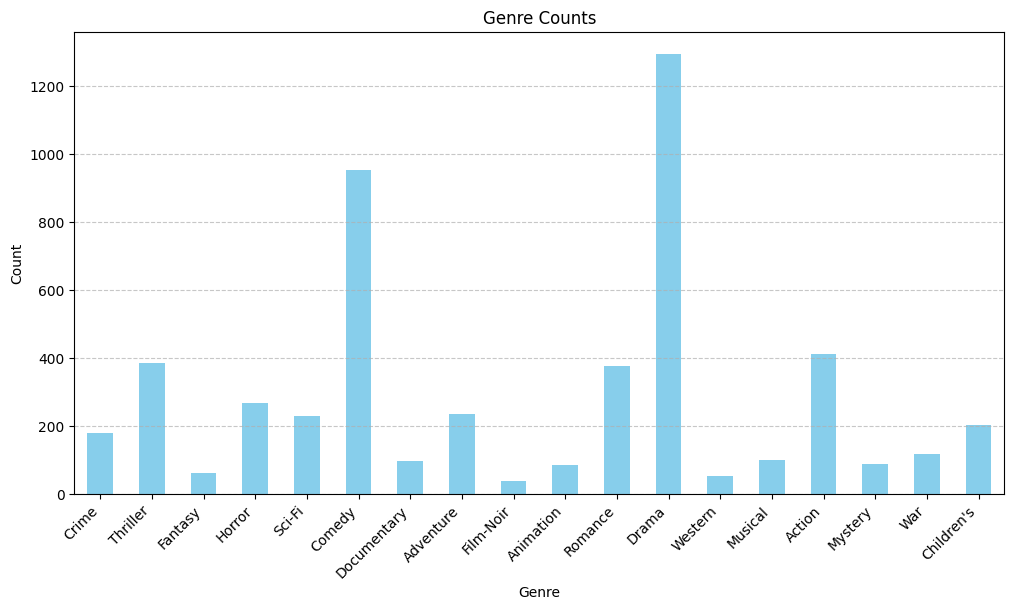

In [234]:
plt.figure(figsize=(12, 6))
data[genre2idx.keys()].sum().plot(kind='bar', color='skyblue')
plt.title('Genre Counts')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Label test

In [51]:
vectors_genre=[]
for genre in data_test.genre.tolist():
    genre_vector = np.zeros(len(genre2idx))
    for g in genre:
        genre_vector[genre2idx[g]] = 1
    vectors_genre.append(genre_vector)
data_test['genre_vectors']=vectors_genre

In [52]:
genre_test = pd.DataFrame(data_test['genre_vectors'].tolist(), columns=genre2idx.keys())
data_test = pd.concat([data_test, genre_test], axis=1)

In [18]:
data_test=data_test.drop('genre_vectors',axis=1)

In [ ]:
data_test

# Train

In [39]:
x_train=np.expand_dims(data['vectors'], 0)
x_train=np.vstack(np.ravel(np.ravel(x_train))) 
y_train=np.expand_dims(data['genre_vectors'], 0)
y_train=np.vstack(np.ravel(np.ravel(y_train))) 


In [236]:
# smote_y_train.value_counts()

Crime
0.0    2926
1.0    2926
Name: count, dtype: int64

In [40]:
x_test=np.expand_dims(data_test['vectors'], 0)
x_test=np.vstack(np.ravel(np.ravel(x_test))) 
y_test=np.expand_dims(data_test['genre_vectors'], 0)
y_test=np.vstack(np.ravel(np.ravel(y_test))) 

In [18]:
pd.DataFrame(y_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
774,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
from sklearn.svm import SVC
from metric3 import map_atk , guess_genre
from sklearn.model_selection import train_test_split

In [53]:
import optunity
import optunity.metrics

In [16]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE,BorderlineSMOTE,ADASYN
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier

## Logistic Regression

### Binary Relevance

In [242]:
y_train=data["Crime"]
def internal_method_logisitic(C):

    model = LogisticRegression(C = C)

    return cross_val_score(model, smote_x_train, smote_y_train, cv=10, scoring='f1').mean()

In [ ]:
params_bayes = {'C': (1e-5,2) }
optimizer = BayesianOptimization(f = internal_method_logisitic,
                                pbounds = params_bayes,
                                random_state = 7,
				                verbose=2,
                                allow_duplicate_points=True)
optimizer.maximize(init_points=2, n_iter=20)
optimal_params = optimizer.max['params']
optimal_C = optimal_params['C']

In [254]:
# logreg = LogisticRegression(C=2.0) #LogisticRegression(C=1.44)
# print('... Processing {}'.format("Crime"))
# y = smote_y_train
# # train the model using X_dtm & y
# logreg.fit(smote_x_train, y)
# # compute the training accuracy
# y_pred_X = logreg.predict(smote_x_train)
# print('Training accuracy is {}'.format(f1_score(y, y_pred_X)))
# # compute the predicted probabilities for X_test_dtm
# test_y_prob = logreg.predict_proba(x_test)[:,1]

... Processing Crime
Training accuracy is 0.9965870307167235


In [255]:
# threshold=0.01
# maxvalue=0
# bestT=0
# for t in range(990):
#     test_y_prob_new=(test_y_prob>=threshold).astype(int)
#     tempval=f1_score(data_test["Crime"],test_y_prob_new)
#     if maxvalue< tempval:
#         maxvalue=tempval
#         bestT=threshold
#     threshold+=0.001
# maxvalue,bestT

(0.1111111111111111, 0.6810000000000005)

In [280]:
smote=SMOTEENN(random_state=27)
smote_x_train,smote_y_train=smote.fit_resample(x_train,data["Crime"])

In [282]:
smote_y_train.value_counts()

Crime
1.0    2913
0.0     618
Name: count, dtype: int64

In [ ]:
# # import and instantiate the Logistic Regression model
#  #LogisticRegression(C=1.44)
# submission_binary = pd.read_csv('submission.csv')
# model_rating=[]
# hype_param_best=[]
# for label in genre2idx.keys():
#     logreg = LogisticRegression(C=0.05)
#     smote=BorderlineSMOTE(random_state=27,k_neighbors=5)
#     smote_x_train,smote_y_train=smote.fit_resample(x_train,data[label])
#     print('... Processing {}'.format(label))
#     # train the model using X_dtm & y
#     logreg.fit(smote_x_train, smote_y_train)
#     # compute the training accuracy
#     model_rating.append(logreg)
#     y_pred_X = logreg.predict_proba(smote_x_train)[:,:1]
#     y_pred_X1 = logreg.predict(smote_x_train)
#     print('Training accuracy(before) is {}'.format(f1_score(smote_y_train, y_pred_X1)))
#     hype_param=0
#     interval=0.01
#     maxScore=0
#     for _ in range(990):
#         interval+=0.001
#         y_pred_new=(y_pred_X>=interval).astype(int)
#         temp_score=f1_score(smote_y_train,y_pred_new)
#         if temp_score>maxScore:
#             maxScore=temp_score
#             hype_param=interval
#     print(f"{label}: maxScore: {maxScore} best T:{hype_param}")

#     hype_param_best.append(hype_param)

#     print('Training accuracy(after) is {}'.format(f1_score(smote_y_train, (y_pred_X>=hype_param).astype(int))))

In [18]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [53]:
vectors_labels=pd.DataFrame(np.array(data_test[genre2idx.keys()]))

In [21]:
import sys
sys.path.insert(0,'./model_class')
from bert_model import BertModel

In [49]:
datasub=pd.DataFrame(pd.read_csv('./cleaned_data/movies_test.csv'))
# test = pd.read_csv('origin_data\movies_test.dat', engine='python',
#                      sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)
weight_path = 'weight\model-fine-tune2.pth'
model = BertModel(weight_path, max_len= 7)
# if os.path.exists(weight_path):
#     print('afasdf')
res = model.predict(datasub)
print(np.array(res).shape)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_fir

(777, 18)


In [80]:
new_dict=dict([(value,key) for key,value in genre2idx.items()])
new_dict

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

In [56]:
res=pd.DataFrame(res)

In [84]:
res.rename(columns=new_dict,inplace=True)

In [58]:
sorted_prediction__trainids = np.argsort(-res,axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.37268447018447015

#### BorderlineSMOTE

In [ ]:
# import and instantiate the Logistic Regression model
logreg = LogisticRegression(C=1.56) #LogisticRegression(C=1.44)
submission_binary = pd.DataFrame(columns=genre2idx.keys())
for label in genre2idx.keys():
    smote=BorderlineSMOTE(random_state=27,k_neighbors=5)
    smote_x_train,smote_y_train=smote.fit_resample(x_train,data[label])
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    logreg.fit(smote_x_train, smote_y_train)
    # compute the training accuracy
    y_pred_X = logreg.predict(smote_x_train)
    print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(x_test)[:,1]
    submission_binary[label] = test_y_prob

In [60]:
for label in genre2idx.keys():
    y_pred_X = model_rating[genre2idx[label]].predict_proba(x_test)[:,:1]
    submission_binary[label]=y_pred_X
    print('Training accuracy is {}'.format(f1_score(data_test[label], (y_pred_X>=hype_param_best[genre2idx[label]]).astype(int))))

Training accuracy is 0.07673267326732673
Training accuracy is 0.24009060022650056
Training accuracy is 0.01785714285714286
Training accuracy is 0.176056338028169
Training accuracy is 0.11636363636363635
Training accuracy is 0.48242187500000006
Training accuracy is 0.07434944237918216
Training accuracy is 0.11636363636363635
Training accuracy is 0.015325670498084292
Training accuracy is 0.052631578947368425
Training accuracy is 0.21584385763490244
Training accuracy is 0.569060773480663
Training accuracy is 0.035398230088495575
Training accuracy is 0.03291139240506329
Training accuracy is 0.20761245674740486
Training accuracy is 0.045283018867924525
Training accuracy is 0.062344139650872814
Training accuracy is 0.11636363636363635


In [112]:
pd.DataFrame(np.array(data_test[genre2idx.keys()]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
774,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
sorted_prediction__trainids = np.argsort(-submission_binary[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5411786786786786

In [319]:
predictions=np.array(submission_binary[genre2idx.keys()])
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT
# map_atk(y_test,predictions,10)

(0.4277534523408555, 0.2970000000000002)

In [ ]:
logreg = LogisticRegression(C=1.44) #LogisticRegression(C=1.44)
submission_binary_combined = pd.DataFrame(columns=genre2idx.keys())
for label in genre2idx.keys():
    smote=SMOTEENN(random_state=27)
    smote_x_train,smote_y_train=smote.fit_resample(x_train,data[label])
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    logreg.fit(smote_x_train, smote_y_train)
    # compute the training accuracy
    y_pred_X = logreg.predict(smote_x_train)
    print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(x_test)[:,1]
    submission_binary_combined[label] = test_y_prob

In [ ]:
submission_binary_combined[genre2idx.keys()]

In [138]:
sorted_prediction__trainids = np.argsort(-submission_binary_combined[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5057546832546833

### Gradient Boosting

In [ ]:
logreg = XGBClassifier(max_depth=6, learning_rate=1e-2) #LogisticRegression(C=1.44)
submission_boost = pd.DataFrame(columns=genre2idx.keys())
for label in genre2idx.keys():
    smote=SMOTEENN(random_state=27)
    smote_x_train,smote_y_train=smote.fit_resample(x_train,data[label])
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    X_train, X_validation, Y_train, Y_validation = train_test_split(smote_x_train, 
                                                              smote_y_train, 
                                                              test_size=0.25)
    logreg.fit(X_train, Y_train, eval_metric="logloss", eval_set=[(X_validation, Y_validation)], early_stopping_rounds=10, verbose=True)
    # compute the training accuracy
    y_pred_X = logreg.predict(smote_x_train)
    print('Training accuracy is {}'.format(f1_score(smote_y_train, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(x_test)[:,1]
    submission_boost[label] = test_y_prob

In [38]:
submission_boost[genre2idx.keys()]
sorted_prediction__trainids = np.argsort(-submission_boost[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.4512844987844987

In [393]:
predictions=np.array(submission_boost[genre2idx.keys()])
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.37435284747112707, 0.8630000000000007)

### Neural network

In [64]:
import tensorflow as tf
from keras import backend as K

In [65]:
from tensorflow.keras import layers, models

In [66]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [67]:
model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dropout(0.8),
    layers.Dense(300, activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(len(genre2idx), activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
history = model.fit(
    x_train, y_train,
    epochs=50,  # Adjust the number of epochs based on your specific requirements
    batch_size=200
)
y_pred_train = model.predict(x_train)
y_pred_train_binary = (y_pred_train > 0.5).astype(int)

# Assuming y_pred_train_binary is in the same format as y_train (binary predictions)
# You may need to adjust the format based on your specific output format

print('Training accuracy is {}'.format(f1_score(y_train, y_pred_train_binary, average='micro')))
y_pred_test = model.predict(x_test)
# Make predictions on the testing set



Epoch 1/50


16/16 [==============================] - 1s 22ms/step - loss: 0.5809 - acc: 0.1108 - f1_m: 0.1631 - precision_m: 0.1564 - recall_m: 0.2401
Epoch 2/50
16/16 [==============================] - 0s 21ms/step - loss: 0.3324 - acc: 0.2147 - f1_m: 0.1438 - precision_m: 0.3624 - recall_m: 0.0901
Epoch 3/50
16/16 [==============================] - 0s 22ms/step - loss: 0.2990 - acc: 0.2527 - f1_m: 0.1861 - precision_m: 0.3520 - recall_m: 0.1269
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 0.2859 - acc: 0.2373 - f1_m: 0.1552 - precision_m: 0.3750 - recall_m: 0.0985
Epoch 5/50
16/16 [==============================] - 0s 24ms/step - loss: 0.2771 - acc: 0.2498 - f1_m: 0.1421 - precision_m: 0.3832 - recall_m: 0.0874
Epoch 6/50
16/16 [==============================] - 0s 21ms/step - loss: 0.2705 - acc: 0.2627 - f1_m: 0.1573 - precision_m: 0.4088 - recall_m: 0.0978
Epoch 7/50
16/16 [==============================] - 0s 21ms/step - loss: 0.2633 - acc: 0.2656 - 

In [578]:
predictions=np.array(y_pred_test).copy()
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.43085761181780874, 0.22100000000000017)

In [77]:
submission_neural=pd.DataFrame(y_pred_test)

In [81]:
submission_neural.rename(columns = new_dict, inplace = True) 

In [45]:
submission_boost[genre2idx.keys()]
sorted_prediction__trainids = np.argsort(-pd.DataFrame(submission_neural),axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5246332046332046

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier

In [24]:
svm_model=SVC(kernel='rbf', C=0.01, gamma=0.5385, probability=True)
multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)
multilabel_classifier = multilabel_classifier.fit(x_train, y_train)


In [25]:
import pickle
with open('./trained_model_params/svm_modelByTitle.pkl', 'wb') as file:
            pickle.dump(multilabel_classifier, file)

In [26]:
y_test_pred = multilabel_classifier.predict_proba(x_test)

# f1_score(y_test,y_test_pred,average='micro')

In [27]:
y_test_pred_svm=y_test_pred.copy()
y_test_pred_svm=np.array(y_test_pred_svm)
submission_svm = pd.read_csv('submission.csv')
i=0
for label in genre2idx.keys():
    submission_svm[label]=y_test_pred_svm[i][:,1]
    i+=1
submission_svm[genre2idx.keys()]


,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
0,0.052388,0.085766,0.017553,0.047432,0.029959,0.358913,0.025432,0.132096,0.011952,0.009268,0.113822,0.368692,0.015071,0.061539,0.081528,0.025350,0.058420,0.285543
1,0.049774,0.110978,0.018673,0.042009,0.052269,0.298965,0.026855,0.064355,0.011464,0.024774,0.107312,0.358935,0.014587,0.031876,0.103609,0.025515,0.031971,0.045153
2,0.048515,0.082972,0.017452,0.924401,0.051143,0.273917,0.028854,0.051483,0.019078,0.019941,0.107947,0.352339,0.008229,0.030006,0.091558,0.020953,0.035023,0.043738
3,0.070496,0.157967,0.018502,0.052650,0.068607,0.375741,0.034541,0.082037,0.012114,0.023979,0.158922,0.396230,0.014563,0.028537,0.122983,0.054794,0.034700,0.050521
4,0.054056,0.103110,0.018724,0.056426,0.054847,0.262357,0.030098,0.058324,0.012319,0.024819,0.122593,0.470444,0.014980,0.031150,0.100459,0.025799,0.037397,0.046854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0.049915,0.158731,0.018066,0.101154,0.080634,0.182865,0.025762,0.053703,0.012526,0.023409,0.094649,0.422823,0.014237,0.029092,0.217897,0.022761,0.047412,0.043098
773,0.088124,0.090358,0.015416,0.409141,0.055998,0.298602,0.028870,0.056503,0.012904,0.023948,0.098220,0.435365,0.011576,0.030768,0.236165,0.023384,0.035385,0.039606
774,0.057898,0.109188,0.018393,0.060384,0.059077,0.306669,0.034469,0.064745,0.010530,0.023494,0.123750,0.511566,0.015812,0.029769,0.107490,0.027763,0.034852,0.064210
775,0.052802,0.144088,0.018161,0.042982,0.056979,0.245807,0.027517,0.057819,0.011471,0.023897,0.100445,0.370947,0.013858,0.031281,0.112095,0.024491,0.033900,0.048185


In [30]:
sorted_prediction__trainids = np.argsort(-submission_svm[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5581570856570857

In [606]:
predictions=np.array(submission_svm[genre2idx.keys()]).copy()
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.45370978332239004, 0.18100000000000013)

### Classifier Chains

In [69]:
from scipy.sparse import csr_matrix, hstack
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [ ]:
logreg_classifier = LogisticRegression(C=1.44)
submission_chains = pd.DataFrame(columns=genre2idx.keys())
data_classifier=data.copy()
x_train_classfier=x_train.copy()
y_train_classfier=y_train.copy()
x_test_classfier=x_test.copy()
y_test_classfier=y_test.copy()

for label in genre2idx.keys():
    print('... Processing {}'.format(label))
    y = data_classifier[label]
    # train the model using X_dtm & y
    logreg_classifier.fit(x_train_classfier, y)
    # compute the training accuracy
    y_pred_X = logreg_classifier.predict(x_train_classfier)
    print('Training accuracy is {}'.format(f1_score(y, y_pred_X)))
    # make predictions from test_X
    test_y = logreg_classifier.predict(x_test_classfier)
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg_classifier.predict_proba(x_test_classfier)[:,1]
    submission_chains[label] = test_y_prob
    x_train_classfier=add_feature(x_train_classfier,y)
    print('Shape of X_dtm is now {}'.format(x_train_classfier.shape))
    # chain current label predictions to test_X_dtm
    x_test_classfier = add_feature(x_test_classfier, test_y)
    print('Shape of test_X_dtm is now {}'.format(x_test_classfier.shape))

In [600]:
predictions1=np.array(submission_chains[genre2idx.keys()])
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions1>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.4440129449838188, 0.16300000000000012)

In [94]:
sorted_prediction__trainids = np.argsort(-submission_chains[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5477995852995853

## Bagging

In [94]:
submission_combined=(submission_binary_combined[genre2idx.keys()]+submission_binary[genre2idx.keys()]+submission_boost[genre2idx.keys()]+submission_neural[genre2idx.keys()]
                     +submission_chains[genre2idx.keys()]+res[genre2idx.keys()])/6
# submission_combined=(submission_binary_combined[genre2idx.keys()]+submission_boost[genre2idx.keys()]+submission_neural+submission_svm[genre2idx.keys()])/5
# → result:(0.4596358639642735, 0.4080000000000003)

In [95]:
submission_combined

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
0,0.176391,0.219013,0.168697,0.206440,0.211677,0.768706,0.183929,0.407105,0.136571,0.202807,0.227849,0.430577,0.118985,0.442738,0.212680,0.191149,0.368403,0.610549
1,0.278060,0.322192,0.162442,0.265155,0.258714,0.547702,0.161921,0.322953,0.163651,0.163514,0.321709,0.659931,0.157544,0.292766,0.319099,0.204790,0.199972,0.215505
2,0.093120,0.311348,0.100230,0.931806,0.330463,0.327700,0.110915,0.223795,0.133798,0.087824,0.158985,0.335821,0.146755,0.104655,0.295868,0.219596,0.130015,0.069956
3,0.278306,0.347612,0.144646,0.252681,0.256591,0.477976,0.139756,0.195668,0.162581,0.120224,0.385473,0.630808,0.136967,0.114726,0.292067,0.290701,0.158189,0.166323
4,0.275387,0.494055,0.214887,0.348526,0.319675,0.446924,0.205570,0.319370,0.179230,0.250376,0.349409,0.693868,0.138196,0.253806,0.343578,0.272239,0.258276,0.308745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,0.258209,0.559333,0.198645,0.368838,0.350797,0.336441,0.186011,0.308926,0.170965,0.238495,0.287940,0.716115,0.130200,0.246497,0.624298,0.260302,0.295158,0.292855
773,0.140243,0.148009,0.158395,0.304174,0.207704,0.348891,0.119633,0.248926,0.099779,0.128757,0.083494,0.373150,0.112462,0.118852,0.664249,0.125234,0.162681,0.226466
774,0.110211,0.196329,0.065961,0.132358,0.078193,0.419790,0.211767,0.115046,0.068812,0.101147,0.179732,0.583268,0.082952,0.070085,0.149504,0.062566,0.084439,0.150476
775,0.287932,0.348579,0.158524,0.417964,0.261506,0.496419,0.161758,0.237357,0.165492,0.158379,0.331855,0.573173,0.157194,0.193174,0.328894,0.208239,0.203074,0.200781


In [96]:
sorted_prediction__trainids = np.argsort(-submission_combined[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.568523881023881

In [107]:
submission_combined.to_csv('submission1.csv')

In [116]:
abc=pd.DataFrame()
abc=submission_combined

In [121]:
movies_train["movieid"].iloc[0]


1650

In [244]:
submission1=pd.read_csv('submission1.csv')
submission2=pd.read_csv('submission2.csv')
submission3=pd.read_csv('submission3.csv')


In [245]:
missing_movie_ids1 = submission2[~submission2['movieid'].isin(submission1['movieid'])]
for label in genre2idx.keys():
    missing_movie_ids1[label]=0
genre_movieid=list(genre2idx.keys())
genre_movieid.append('movieid')
submission1 = pd.concat([submission1[genre_movieid], missing_movie_ids1[genre_movieid]], ignore_index=True).sort_values(by='movieid')


C:\Users\admin\AppData\Local\Temp\ipykernel_2836\572759920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_movie_ids1[label]=0


In [246]:
missing_movie_ids3 = submission2[~submission2['movieid'].isin(submission3['movieid'])]
for label in genre2idx.keys():
    missing_movie_ids3[label]=0
genre_movieid=list(genre2idx.keys())
genre_movieid.append('movieid')
submission3 = pd.concat([submission3[genre_movieid], missing_movie_ids3[genre_movieid]], ignore_index=True).sort_values(by='movieid')

C:\Users\admin\AppData\Local\Temp\ipykernel_2836\2670123946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_movie_ids3[label]=0


In [253]:
submission2=submission2.sort_values(by='movieid')


In [280]:
data_sorted=data.sort_values(by='movieid').set_index('movieid')
vectors_labels=pd.DataFrame(np.array(data_sorted[genre2idx.keys()]))
w1=0
w2=1
w3=0

In [ ]:
submission2=submission2.set_index('movieid')
submission1=submission1.set_index('movieid')
submission3=submission3.set_index('movieid')

In [303]:
submission3=submission3.set_index('movieid')

In [304]:
submission3

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
movieid,,,,,,,,,,,,,,,,,,
1,3.870663e-07,5.588573e-03,4.905767e-01,9.714553e-01,0.759675,4.993133e-07,5.294202e-08,0.001620,6.519864e-03,2.471888e-10,1.180897e-09,0.157409,8.858831e-09,0.000003,7.059093e-06,2.320997e-08,0.000005,0.000002
2,7.646935e-02,7.114165e-01,7.515992e-02,7.919439e-01,0.395226,2.943085e-04,2.400148e-05,0.028851,2.953669e-01,2.462466e-06,3.286522e-05,0.057991,3.826486e-05,0.001347,5.744367e-02,2.386100e-04,0.010462,0.001200
3,2.703023e-09,6.300670e-08,2.244248e-07,1.101623e-04,0.998038,2.711532e-09,7.601015e-08,0.025326,2.474137e-06,4.268960e-15,2.123879e-12,0.007880,1.670983e-12,0.925919,9.657675e-09,4.077637e-15,0.000075,0.000042
4,6.709979e-06,2.027540e-06,9.660791e-08,3.736447e-06,0.724210,1.777470e-04,4.004234e-05,0.900848,1.284414e-06,2.511105e-07,2.761061e-08,0.001773,1.778810e-05,0.198830,1.078945e-06,1.205497e-06,0.007763,0.000331
5,8.953288e-06,7.385816e-06,4.384601e-07,6.189873e-05,0.983944,8.971808e-07,3.012010e-07,0.003301,3.472895e-06,9.501677e-12,1.861406e-08,0.001732,6.593625e-10,0.000575,6.486861e-06,4.955769e-10,0.000130,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,1.828408e-03,5.222157e-01,4.428852e-01,9.723589e-01,0.431562,3.014984e-05,2.223346e-07,0.002530,2.268593e-01,7.400577e-08,2.561600e-07,0.112610,1.732802e-06,0.000028,3.686572e-03,3.434829e-05,0.000162,0.000019
3947,5.709537e-04,1.113671e-04,3.283138e-07,2.886468e-06,0.069801,3.842392e-04,6.744616e-07,0.001841,1.744801e-06,3.459906e-07,5.272710e-06,0.000015,4.058358e-06,0.000007,2.639322e-04,1.360133e-04,0.000074,0.000008
3948,9.325756e-08,1.222899e-07,5.033113e-09,5.860165e-06,0.998683,1.283153e-09,5.818299e-10,0.000045,5.115896e-08,5.768047e-17,9.404320e-11,0.000235,1.775717e-14,0.000003,1.760225e-07,2.757559e-14,0.000002,0.000003


In [310]:
sorted_prediction__trainids = np.argsort(-w2*submission2[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.941039475567003

In [312]:

sorted_prediction__trainids = np.argsort(-(w1*submission1[genre2idx.keys()]+w2*submission2[genre2idx.keys()]+w3*submission3[genre2idx.keys()]),axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.941039475567003

In [309]:
w2*submission2[genre2idx.keys()]+w1*submission1[genre2idx.keys()]+w3*submission3[genre2idx.keys()]

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
movieid,,,,,,,,,,,,,,,,,,
1,0.214781,0.215216,0.290702,0.184731,0.185374,0.833312,0.177995,0.240563,0.136458,0.611270,0.395927,0.499450,0.144926,0.194126,0.231850,0.160504,0.195047,0.696347
2,0.336253,0.386172,0.576214,0.314173,0.345325,0.491683,0.202596,0.534830,0.194177,0.246026,0.383965,0.601640,0.195757,0.255639,0.420887,0.244757,0.247165,0.475969
3,0.389836,0.252990,0.127938,0.188214,0.215542,0.886611,0.122305,0.393290,0.136478,0.114078,0.617529,0.540807,0.169220,0.136862,0.427944,0.178941,0.140781,0.200302
4,0.266623,0.301254,0.167956,0.164441,0.216494,0.900115,0.149521,0.210166,0.130727,0.125084,0.390068,0.779512,0.133544,0.148458,0.327193,0.156889,0.208634,0.221387
5,0.118297,0.167701,0.064509,0.587141,0.351221,0.813508,0.164921,0.139737,0.073927,0.147434,0.121471,0.090714,0.088341,0.149511,0.190585,0.090567,0.166557,0.107251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3945,0.186683,0.380050,0.202299,0.223847,0.408899,0.487908,0.234430,0.651804,0.145972,0.781890,0.184543,0.305934,0.129773,0.228166,0.396937,0.202232,0.345652,0.773757
3947,0.215519,0.661017,0.140618,0.207068,0.202069,0.445537,0.256794,0.211014,0.144831,0.130206,0.244069,0.618198,0.141478,0.147178,0.439926,0.172865,0.154578,0.160757
3948,0.300377,0.384110,0.250857,0.395989,0.371444,0.816830,0.232664,0.361447,0.204866,0.285412,0.374000,0.435701,0.151491,0.348460,0.371724,0.317198,0.289299,0.366677


In [269]:
w1*submission2[genre2idx.keys()]

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### remove

In [191]:
common_movieids = list(set(submission1['movieid']).intersection(submission2['movieid']).intersection(submission3['movieid']))

In [196]:
submission1=submission1[submission1['movieid'].isin(common_movieids)]

In [197]:
submission2=submission2[submission2['movieid'].isin(common_movieids)]

In [198]:
submission3=submission3[submission3['movieid'].isin(common_movieids)]

In [168]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [201]:
movies_train[movies_train['movieid'].isin(common_movieids)]

,movieid,title,genre
0,1650,Washington Square (1997),[Drama]
1,185,"Net, The (1995)","[Sci-Fi, Thriller]"
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3,3204,"Boys from Brazil, The (1978)",[Thriller]
7,2382,Police Academy 5: Assignment: Miami Beach (1988),[Comedy]
...,...,...,...
3099,2921,High Plains Drifter (1972),[Western]
3100,502,"Next Karate Kid, The (1994)","[Action, Children's]"
3101,2539,Analyze This (1999),[Comedy]
3102,3038,"Face in the Crowd, A (1957)",[Drama]


In [314]:
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
def internal_method(w1,w2,w3):
    if w1+w2+w3>1:
        return -1
    else:
        sorted_prediction__trainids = np.argsort(-(w1*submission1[genre2idx.keys()]+w2*submission2[genre2idx.keys()]+w3*submission3[genre2idx.keys()]),axis=1)
        top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
        vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
        return mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

In [315]:
params_bayes = {'w1': (0,1),
          'w2': (0,1),
           'w3':(0,1) }
optimizer = BayesianOptimization(f = internal_method,
                                pbounds = params_bayes,
                                random_state = 7,
				                verbose=2)
optimizer.maximize(init_points=5, n_iter=100)

|   iter    |  target   |    w1     |    w2     |    w3     |
-------------------------------------------------------------
| 1         | -1.0      | 0.07631   | 0.7799    | 0.4384    |
| 2         | -1.0      | 0.7235    | 0.978     | 0.5385    |
| 3         | 0.3481    | 0.5011    | 0.07205   | 0.2684    |
| 4         | -1.0      | 0.4999    | 0.6792    | 0.8037    |
| 5         | 0.3432    | 0.3809    | 0.06594   | 0.2881    |
| 6         | 0.2441    | 1.0       | 0.0       | 0.0       |
| 7         | 0.06505   | 0.0       | 0.0       | 0.0       |
| 8         | -1.0      | 1.0       | 0.0       | 1.0       |
| 9         | 0.2441    | 0.4968    | 0.0       | 0.0       |
| 10        | 0.08325   | 0.0       | 0.0       | 0.8522    |
| 11        | -1.0      | 1.0       | 0.4752    | 0.0       |
| 12        | 0.08325   | 0.0       | 0.0       | 0.4433    |
| 13        | -1.0      | 0.4454    | 0.0       | 0.5685    |
| 14        | 0.8885    | 0.319     | 0.2756    | 0.08089   |
| 15    

In [317]:
optimal_value=optimizer.max['params']

In [318]:
optimal_value['w1']

0.05445067852011942

In [608]:
predictions=np.array(submission_combined[genre2idx.keys()])
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    predictions_new=(predictions>=threshold).astype(int)
    tempval=f1_score(y_test,predictions_new,average="micro")
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.46315054139015016, 0.43500000000000033)

In [96]:
sorted_prediction__trainids = np.argsort(-submission_combined[genre2idx.keys()],axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

0.5593050193050193

In [131]:
model2=ModelByTitle(movies_train)
model2.preprocess_data()

In [132]:
model2.predict(movies_test)
print(pd.DataFrame(model2.test_neural))

25/25 [==============================] - 0s 1ms/step
           0         1         2         3         4         5         6   \
0    0.000996  0.000336  0.023852  0.004608  0.004325  0.898872  0.026702   
1    0.025985  0.019138  0.020980  0.006205  0.017233  0.632488  0.020173   
2    0.000005  0.001509  0.000002  0.999687  0.013229  0.000322  0.000223   
3    0.006906  0.062737  0.000819  0.031431  0.016090  0.042370  0.005411   
4    0.006996  0.010060  0.001840  0.002219  0.002843  0.289518  0.010110   
..        ...       ...       ...       ...       ...       ...       ...   
772  0.020495  0.453637  0.001125  0.031424  0.044346  0.000386  0.002457   
773  0.044798  0.010418  0.014248  0.008039  0.021369  0.038846  0.019337   
774  0.000912  0.000125  0.000534  0.000107  0.000222  0.631757  0.001095   
775  0.067628  0.095743  0.011778  0.013907  0.023421  0.170064  0.019597   
776  0.002932  0.065224  0.000471  0.666318  0.023094  0.039309  0.003314   

           7         8

In [123]:
model2.evaluate_model()

0.5649435149435149


In [107]:
neural=load_model('./trained_model_params/neuralbytitle.h5', custom_objects={'f1_m': neural_metrics.f1_m, 
                                                               'precision_m': neural_metrics.precision_m, 
                                                               'recall_m': neural_metrics.recall_m})
submission_neural = neural.predict(x_test)
sorted_prediction__trainids = np.argsort(-pd.DataFrame(submission_neural),axis=1)
top_10_prediction_trainids = sorted_prediction__trainids[:,:5]
def get_column_names_train(row):
    return list(vectors_labels.columns[row == 1])
vectors_labels_new=vectors_labels.apply(get_column_names_train,axis=1).tolist()
mapk(vectors_labels_new,top_10_prediction_trainids,k=5)

25/25 [==============================] - 0s 2ms/step


0.5349006149006149

In [ ]:
# from sklearn.metrics import average_precision_score
# sorted_indices = np.argsort(predictions[0])[::-1]
# top_k_indices = sorted_indices[:3]
# y_true_k = np.array(y_test[0])[top_k_indices]
# y_score_k = np.array(predictions[0])[top_k_indices]
# y_score_k=np.ones(y_score_k.shape[0])
# map_at_k_instance = average_precision_score(y_true_k, y_score_k)
# print(y_true_k,"--",y_score_k)
# map_at_k_instance


In [213]:
# y_score=predictions.copy()
# sorted_indices = np.argsort(y_score[0])[::-1]
# top_k_indices = sorted_indices[:3]
# y_true_k = np.array(y_test[0])[top_k_indices]
# y_score_k = np.array(y_score[0])[top_k_indices]
# y_score[0]=[0 if i not in top_k_indices else 1 for i in range(18) ]

In [241]:
submission3

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's,movieid
838,3.870663e-07,5.588573e-03,4.905767e-01,9.714553e-01,0.759675,4.993133e-07,5.294202e-08,0.001620,6.519864e-03,2.471888e-10,1.180897e-09,0.157409,8.858831e-09,0.000003,7.059093e-06,2.320997e-08,0.000005,0.000002,1
278,7.646935e-02,7.114165e-01,7.515992e-02,7.919439e-01,0.395226,2.943085e-04,2.400148e-05,0.028851,2.953669e-01,2.462466e-06,3.286522e-05,0.057991,3.826486e-05,0.001347,5.744367e-02,2.386100e-04,0.010462,0.001200,2
1392,2.703023e-09,6.300670e-08,2.244248e-07,1.101623e-04,0.998038,2.711532e-09,7.601015e-08,0.025326,2.474137e-06,4.268960e-15,2.123879e-12,0.007880,1.670983e-12,0.925919,9.657675e-09,4.077637e-15,0.000075,0.000042,3
339,6.709979e-06,2.027540e-06,9.660791e-08,3.736447e-06,0.724210,1.777470e-04,4.004234e-05,0.900848,1.284414e-06,2.511105e-07,2.761061e-08,0.001773,1.778810e-05,0.198830,1.078945e-06,1.205497e-06,0.007763,0.000331,4
844,8.953288e-06,7.385816e-06,4.384601e-07,6.189873e-05,0.983944,8.971808e-07,3.012010e-07,0.003301,3.472895e-06,9.501677e-12,1.861406e-08,0.001732,6.593625e-10,0.000575,6.486861e-06,4.955769e-10,0.000130,0.000100,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1.828408e-03,5.222157e-01,4.428852e-01,9.723589e-01,0.431562,3.014984e-05,2.223346e-07,0.002530,2.268593e-01,7.400577e-08,2.561600e-07,0.112610,1.732802e-06,0.000028,3.686572e-03,3.434829e-05,0.000162,0.000019,3945
2090,5.709537e-04,1.113671e-04,3.283138e-07,2.886468e-06,0.069801,3.842392e-04,6.744616e-07,0.001841,1.744801e-06,3.459906e-07,5.272710e-06,0.000015,4.058358e-06,0.000007,2.639322e-04,1.360133e-04,0.000074,0.000008,3947
2210,9.325756e-08,1.222899e-07,5.033113e-09,5.860165e-06,0.998683,1.283153e-09,5.818299e-10,0.000045,5.115896e-08,5.768047e-17,9.404320e-11,0.000235,1.775717e-14,0.000003,1.760225e-07,2.757559e-14,0.000002,0.000003,3948
1197,1.977016e-06,1.358552e-07,1.562951e-10,2.349096e-08,0.223578,1.670921e-04,5.517305e-06,0.990480,9.491729e-09,1.016626e-07,2.456722e-09,0.000057,3.429307e-05,0.016114,9.864890e-08,5.276322e-06,0.006156,0.000029,3949


## SVM

In [ ]:
clf = SVC(kernel='rbf', C=0.3, gamma=1, shrinking=False, probability=True)
for label in genre2idx.keys():
    print('... Processing {}'.format("Crime"))
    y = data[label]
    # train the model 
    clf.fit(x_train, y)
    # compute the training accuracy
    y_pred_X = clf.predict(x_train)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for x_test
    test_y_prob = clf.predict_proba(x_test)[:,1]
    submission_binary[label] = test_y_prob

### HyperParameter Tuning

#### GridSearch (Dont need to run again)

In [ ]:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
          'gamma': [0.00001, 0.0001, 0.001, 0.01,0.1],
          'kernel':['linear','rbf','poly'] }
grid_clf = GridSearchCV(SVC(), params,cv=10)

#Fit the data with the best possible parameters
grid_clf.fit(x_train, data["Crime"])

In [ ]:
grid_clf.best_estimator_

#### Bayesian Optimization

In [610]:
def internal_method(C,gamma):
    svm_model=SVC(kernel='rbf', C=C, gamma=gamma, probability=True)
    multilabel_classifier = MultiOutputClassifier(svm_model, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    return cross_val_score(multilabel_classifier, x_train, y_train, cv=5, scoring='f1_micro').mean()

    

In [ ]:
params_bayes = {'C': (1e-5,2),
          'gamma': (1e-4,2) }
optimizer = BayesianOptimization(f = internal_method,
                                pbounds = params_bayes,
                                random_state = 7,
				                verbose=2)
optimizer.maximize(init_points=10, n_iter=5)
optimal_params = optimizer.max['params']
optimal_C = optimal_params['C']
optimal_gamma = optimal_params['gamma']

In [ ]:
optimal_C,optimal_gamma

In [50]:
from sklearnex import patch_sklearn, config_context

In [187]:
submission_SVM = pd.read_csv('submission.csv')

In [51]:
patch_sklearn()
clf = SVC(kernel='rbf', C=1.94, gamma=0.5385, probability=True)
print('... Processing {}'.format("Crime"))
y = data["Crime"]
# train the model
with config_context(target_offload="gpu:0"): 
    clf.fit(x_train, y)
# compute the training accuracy
y_pred_X = clf.predict(x_train)
print('Training accuracy is {}'.format(f1_score(y, y_pred_X)))
# compute the predicted probabilities for x_test
test_y_prob = clf.predict_proba(x_test)[:,1]

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


... Processing Crime
Training accuracy is 0.983050847457627


In [46]:
clf = SVC(kernel='rbf', C=1.956, gamma=0.5385, probability=True)
smote=BorderlineSMOTE(random_state=10,k_neighbors=10)
label="Drama"
smote_x_train,smote_y_train=smote.fit_resample(x_train,data[label])
print('... Processing {}'.format(label))
y = smote_y_train
# train the model 
clf.fit(smote_x_train, y)
# compute the training accuracy
y_pred_X = clf.predict(smote_x_train)
print('Training accuracy is {}'.format(f1_score(y, y_pred_X)))
# compute the predicted probabilities for x_test
test_y_prob = clf.predict_proba(x_test)[:,1]

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


... Processing Drama
Training accuracy is 0.9991724137931035


In [ ]:
y_pred_X = clf.predict(smote_x_train)

In [344]:
threshold=0.01
maxvalue=0
bestT=0
for t in range(990):
    test_y_prob_new=(test_y_prob>=threshold).astype(int)
    tempval=f1_score(data_test["Crime"],test_y_prob_new)
    if maxvalue< tempval:
        maxvalue=tempval
        bestT=threshold
    threshold+=0.001
maxvalue,bestT

(0.09404388714733543, 0.3950000000000003)

In [218]:
pd.DataFrame((test_y_prob>=0.271).astype(int)).iloc[21*18:21*18+20]

,0
378,0
379,0
380,0
381,0
382,0
383,0
384,0
385,0
386,1
387,0


In [220]:
data_test[genre2idx.keys()].iloc[21*18:21*18+20]

,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
378,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
379,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
381,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
382,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
384,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
385,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
386,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
387,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
submission_binary.to_csv('submission.csv',index=False)

In [99]:
submission_binary.head()

,Crime\tThriller\tFantasy\tHorror\tSci-Fi\tComedy\tDocumentary\tAdventure\tFilm-Noir\tAnimation\tRomance\tDrama\tWestern\tMusical\tAction\tMystery\tWar\tChildren's,Crime,Thriller,Fantasy,Horror,Sci-Fi,Comedy,Documentary,Adventure,Film-Noir,Animation,Romance,Drama,Western,Musical,Action,Mystery,War,Children's
0,NaN,0.054053,0.078331,0.018728,0.052084,0.046935,0.350676,0.031112,0.094403,0.012341,0.024265,0.118971,0.386623,0.016305,0.037056,0.093012,0.025517,0.053444,0.092527
1,NaN,0.056664,0.103570,0.019183,0.051906,0.061299,0.310440,0.029980,0.073301,0.012375,0.026629,0.116200,0.373645,0.016557,0.032931,0.107148,0.026250,0.037375,0.051292
2,NaN,0.054093,0.075493,0.018808,0.376041,0.050614,0.277523,0.033134,0.065633,0.012336,0.026457,0.120092,0.362337,0.016434,0.032333,0.096719,0.025204,0.037982,0.052329
3,NaN,0.059661,0.098490,0.019580,0.055874,0.056423,0.344480,0.038163,0.074960,0.012383,0.027207,0.131152,0.407442,0.016767,0.032472,0.116767,0.029274,0.038663,0.058814
4,NaN,0.055432,0.099403,0.018943,0.070945,0.057706,0.251765,0.029747,0.066385,0.012361,0.026224,0.114059,0.485583,0.016185,0.032288,0.113561,0.027046,0.036509,0.050346


## Parameters and hyperparameters

In [62]:
epochs=100
rate=0.1
batch_size=200
layer_size=512
w1=nn.Parameter(3899,layer_size)
w2=nn.Parameter(layer_size,18)
b1=nn.Parameter(1,layer_size)
b2=nn.Parameter(1,18)

In [37]:
def run(x):
    z1=nn.AddBias(nn.Linear(x,w1),b1)
    a1=nn.ReLU(z1)
    # z2=nn.AddBias(nn.Linear(a1,w2),b2) 
    # a2=nn.ReLU(z2)
    z2=nn.AddBias(nn.Linear(a1,w2),b2) 
    yhat=z2
    return yhat
def get_loss(x, y):
    return nn.SoftmaxLoss(run(x),y)

In [38]:
def get_validation_accuracy():
    dev_logits = run(nn.Constant(x_test)).data
    dev_predicted = np.argmax(dev_logits, axis=1)
    dev_accuracy = np.mean(dev_predicted == y_test)
    return dev_accuracy

In [43]:

def train(x_train,y_train):
    noExamples=x_train.shape[0]
    for _ in range(epochs):
        start_idx=np.random.randint(noExamples)
        end_idx=min(start_idx+batch_size,noExamples)
        xSample=x_train[start_idx:end_idx]
        ySample=y_train[start_idx:end_idx]
        grad_wrt_w1,grad_wrt_w2,grad_wrt_b1,grad_wrt_b2 = nn.gradients(get_loss(nn.Constant(xSample), nn.Constant(ySample)), [w1,w2,b1,b2])
        print(get_validation_accuracy())
        if get_validation_accuracy()>=0.2:
            break
        w1.update(grad_wrt_w1,rate)
        w2.update(grad_wrt_w2,rate)
        b1.update(grad_wrt_b1,rate)
        b2.update(grad_wrt_b2,rate)
        

In [60]:
from sklearn.preprocessing import normalize
y_train_standard=normalize(y_train,norm='l1',axis=1)
y_train_standard[2]

array([0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ])

In [ ]:
train(x_train,y_train_standard)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)
svm_model = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [78]:
y_flattened = y_train.argmax(axis=1)
y_flattened

array([11,  1,  0, ..., 11,  5,  2], dtype=int64)

In [56]:
# input array
in_arr = np.array([0.12681672, 0.1958262 , 0.28140433 ,0.04834938 ,0.07772  ,  0.02590886,
 0.06871412, 0.04280739, 0.05009817 ,0.04869181 ,0.03366302])
print("Input unsorted array : ", in_arr)
 
sorted_indices = np.argsort(in_arr)[::-1]
top_k_indices = sorted_indices[:3]
y_score_k = np.array(in_arr)[top_k_indices]
y_score_k

Input unsorted array :  [0.12681672 0.1958262  0.28140433 0.04834938 0.07772    0.02590886
 0.06871412 0.04280739 0.05009817 0.04869181 0.03366302]


array([0.28140433, 0.1958262 , 0.12681672])